In [1]:
from model.rnn import LSTM
from model.hidden_markov_model import HMM
from model.nn import NN
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
occupancy = pd.read_csv(r'C:\Users\ASUS\Desktop\activity inference\data\eco\home1\01_occupancy_csv\01_summer.csv',index_col=0)
# timestamps = pd.date_range(start=occupancy.index[0], end=pd.to_datetime(occupancy.index[-1])+pd.Timedelta(days=1), freq='S')
occupancy_state = []
for i in range(len(occupancy)):
    date = occupancy.index[i]
    timestamps = pd.date_range(start=date,end=pd.to_datetime(date)+pd.Timedelta(days=1)-pd.Timedelta(seconds=1),freq='s')
    data = occupancy.iloc[i,:]
    series = pd.DataFrame(index=timestamps, data=data.values,columns=["occupancy"]).resample('1min').max()
    occupancy_state.append(series)
occupancy_state = pd.concat(occupancy_state)

In [3]:
timestamps = occupancy_state.index

In [4]:
date

'25-Aug-2012'

# prepare electricity

In [1]:
# prepare electricity
hdf = pd.HDFStore(r'C:\Users\ASUS\Desktop\activity inference\data\eco\eco.h5')
power_info = hdf.get('/building1/elec/meter1')
power_info.index.name = 'Date'
power_info.reset_index(inplace=True)
power_info['Date'] = pd.to_datetime(power_info['Date']).dt.tz_localize(None)
#转化时间戳
power_info.set_index('Date', drop=True, inplace=True)
power_info=power_info.fillna(0)
power_info = power_info["power"]["active"].to_frame()
power_info=power_info.resample("1min").mean()
power_info=power_info.fillna(0)
date = power_info.index
electricity_data = power_info.loc[np.intersect1d(pd.to_datetime(date), pd.to_datetime(timestamps))]
class Dataset:
    def __init__(self, occupancy, electricity_dat):
        self.occupancy = occupancy
        self.data = electricity_dat

NameError: name 'pd' is not defined

In [6]:
occupancy_state = occupancy_state.loc[np.intersect1d(pd.to_datetime(date), pd.to_datetime(timestamps))]

In [7]:
occupancy_state

,occupancy
2012-07-15 00:00:00,1
2012-07-15 00:01:00,1
2012-07-15 00:02:00,1
2012-07-15 00:03:00,1
2012-07-15 00:04:00,1
...,...
2012-08-25 23:55:00,1
2012-08-25 23:56:00,1
2012-08-25 23:57:00,1
2012-08-25 23:58:00,1


In [26]:
sliding_window = []
lag = 10
for i in range(len(electricity_data)-lag):
    sliding_window.append(electricity_data[i:i+lag].values)
power_sliding = np.array(sliding_window).reshape(-1,lag)

num_indices = 24
sin_encoding = np.sin(2 * np.pi * electricity_data.index.hour / num_indices)
cos_encoding = np.cos(2 * np.pi * electricity_data.index.hour / num_indices)

# 将编码后的索引作为新列添加到DataFrame
electricity_data['sin_index'] = sin_encoding
electricity_data['cos_index'] = cos_encoding
time_info = electricity_data[:-lag].iloc[:,[1,2]]
electricity_data = np.concatenate([power_sliding,time_info],axis=1)
occupancy_state_reserve = occupancy_state.values[:-lag]

In [27]:
occupancy_state

,occupancy
2012-07-15 00:00:00,1
2012-07-15 00:01:00,1
2012-07-15 00:02:00,1
2012-07-15 00:03:00,1
2012-07-15 00:04:00,1
...,...
2012-08-25 23:55:00,1
2012-08-25 23:56:00,1
2012-08-25 23:57:00,1
2012-08-25 23:58:00,1


In [28]:
from sklearn.preprocessing import OneHotEncoder
occupancy_state = OneHotEncoder().fit_transform(occupancy_state.values).toarray()[:-lag]

In [29]:
from sklearn.preprocessing import MinMaxScaler
electricity_data = MinMaxScaler().fit_transform(electricity_data)
training = 0.6
validation = 0.2
test = 0.2
validation_end = int(len(electricity_data)*validation)
training_end = validation_end + int(len(electricity_data)*training)
test_start = int(len(electricity_data)*test)
validation_dataset = Dataset(occupancy_state[:validation_end], electricity_data[:validation_end])
train_dataset = Dataset(occupancy_state[validation_end:training_end], electricity_data[validation_end:training_end])
test_dataset = Dataset(occupancy_state[-test_start:], electricity_data[-test_start:])

In [30]:
test_dataset.occupancy

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [ ]:
hidden_states = [5,6,7,8,9]
# score = []
# for i in hidden_states:
#     hmm = HMM(train_dataset, validation_dataset,number_of_hidden_states=i)
#     prediction = hmm.run()
#
#     from sklearn.metrics import f1_score
#     f1=f1_score(validation_dataset.occupancy, prediction)
#     score.append(f1)
lstm = LSTM(train_dataset, test_dataset,epoch=10)
prediction1 = lstm.run()

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, recall_score
f1=f1_score(occupancy_state_reserve[-test_start:], prediction1,average='macro')
print(f1)
print(accuracy_score(occupancy_state_reserve[-test_start:], prediction1))
print(recall_score(occupancy_state_reserve[-test_start:], prediction1))

In [1]:
np.save(r"C:\Users\ASUS\Desktop\OccupancyWatch\result\ECO\b1\same_prediction_lag{}".format(lag), prediction1)
np.save(r"C:\Users\ASUS\Desktop\OccupancyWatch\result\ECO\b1\ground_truth_lag{}".format(lag), occupancy_state_reserve[-test_start:])

NameError: name 'np' is not defined

# test on another dataset

In [31]:
occupancy = pd.read_csv(r'C:\Users\ASUS\Desktop\activity inference\data\eco\home1\01_occupancy_csv\01_winter.csv',index_col=0)
# timestamps = pd.date_range(start=occupancy.index[0], end=pd.to_datetime(occupancy.index[-1])+pd.Timedelta(days=1), freq='S')
occupancy_state = []
for i in range(len(occupancy)):
    date = occupancy.index[i]
    timestamps = pd.date_range(start=date,end=pd.to_datetime(date)+pd.Timedelta(days=1)-pd.Timedelta(seconds=1),freq='S')
    data = occupancy.iloc[i,:]
    series = pd.DataFrame(index=timestamps, data=data.values,columns=["occupancy"]).resample('1min').max()
    occupancy_state.append(series)
occupancy_state = pd.concat(occupancy_state)
timestamps = occupancy_state.index

In [32]:
# prepare electricity
hdf = pd.HDFStore(r'C:\Users\ASUS\Desktop\activity inference\data\eco\eco.h5')
power_info = hdf.get('/building1/elec/meter1')
power_info.index.name = 'Date'
power_info.reset_index(inplace=True)
power_info['Date'] = pd.to_datetime(power_info['Date']).dt.tz_localize(None)
#转化时间戳
power_info.set_index('Date', drop=True, inplace=True)
power_info=power_info.fillna(0)
power_info = power_info["power"]["active"].to_frame()
power_info=power_info.resample("1min").mean()
power_info=power_info.fillna(0)
date = power_info.index
electricity_data = power_info.loc[np.intersect1d(pd.to_datetime(date), pd.to_datetime(timestamps))]
from sklearn.preprocessing import MinMaxScaler

class Dataset:
    def __init__(self, occupancy, electricity_dat):
        self.occupancy = occupancy
        self.data = electricity_dat

In [33]:
occupancy_state = occupancy_state.loc[np.intersect1d(pd.to_datetime(date), pd.to_datetime(timestamps))]

In [36]:
occupancy_state[:-120]

,occupancy
2012-11-24 00:00:00,1
2012-11-24 00:01:00,1
2012-11-24 00:02:00,1
2012-11-24 00:03:00,1
2012-11-24 00:04:00,1
...,...
2013-01-09 21:55:00,1
2013-01-09 21:56:00,1
2013-01-09 21:57:00,1
2013-01-09 21:58:00,1


In [37]:
electricity_data

,active
Date,
2012-11-24 00:00:00,2194.642334
2012-11-24 00:01:00,1108.750610
2012-11-24 00:02:00,62.362000
2012-11-24 00:03:00,62.267502
2012-11-24 00:04:00,66.895271
...,...
2013-01-09 23:55:00,2168.175537
2013-01-09 23:56:00,2137.889160
2013-01-09 23:57:00,2147.401367


In [38]:
sliding_window = []
lag = 10
for i in range(len(electricity_data)-lag):
    sliding_window.append(electricity_data[i:i+lag].values)
power_sliding = np.array(sliding_window).reshape(-1,lag)

num_indices = 24
sin_encoding = np.sin(2 * np.pi * electricity_data.index.hour / num_indices)
cos_encoding = np.cos(2 * np.pi * electricity_data.index.hour / num_indices)

# 将编码后的索引作为新列添加到DataFrame
electricity_data['sin_index'] = sin_encoding
electricity_data['cos_index'] = cos_encoding
time_info = electricity_data[:-lag].iloc[:,[1,2]]
electricity_data = np.concatenate([power_sliding,time_info],axis=1)
electricity_data = MinMaxScaler().fit_transform(electricity_data)

In [39]:
occupancy_state

,occupancy
2012-11-24 00:00:00,1
2012-11-24 00:01:00,1
2012-11-24 00:02:00,1
2012-11-24 00:03:00,1
2012-11-24 00:04:00,1
...,...
2013-01-09 23:55:00,1
2013-01-09 23:56:00,1
2013-01-09 23:57:00,1
2013-01-09 23:58:00,1


In [40]:
occupancy_state = occupancy_state[:-10]
from sklearn.preprocessing import OneHotEncoder
occupancy_state = OneHotEncoder().fit_transform(occupancy_state.values).toarray()

In [41]:
test_dataset2 = Dataset(occupancy_state,electricity_data)

In [42]:
test_dataset2.data

array([[0.41958662, 0.20975534, 0.00755742, ..., 0.00747854, 0.5       ,
        1.        ],
       [0.20975534, 0.00755742, 0.00753916, ..., 0.00745571, 0.5       ,
        1.        ],
       [0.00755742, 0.00753916, 0.0084334 , ..., 0.00744119, 0.5       ,
        1.        ],
       ...,
       [0.01642407, 0.41205695, 0.41816515, ..., 0.40861997, 0.37059048,
        0.98296291],
       [0.41205695, 0.41816515, 0.41762295, ..., 0.41045805, 0.37059048,
        0.98296291],
       [0.41816515, 0.41762295, 0.41683331, ..., 0.40932757, 0.37059048,
        0.98296291]])

In [42]:
# score = []
# for i in hidden_states:
#     hmm = HMM(train_dataset, validation_dataset,number_of_hidden_states=i)
#     prediction = hmm.run()
#
#     from sklearn.metrics import f1_score
#     f1=f1_score(validation_dataset.occupancy, prediction)
#     score.append(f1)
lstm = LSTM(train_dataset, test_dataset2,epoch=10)
prediction = lstm.run()

Epoch 00, Loss: 373.6660622615018


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\ASUS\AppData\Local\Temp/ipykernel_33540/3651869894.py", line 10, in <module>
    prediction = lstm.run()
  File "C:\Users\ASUS\Desktop\OccupancyWatch\core\model\rnn.py", line 74, in run
    loss = model.train_on_batch(epoch_x, epoch_y)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2680, in train_on_batch
    iterator = data_adapter.single_batch_iterator(
  File "C:\Users\ASUS\anaconda3\lib\site-packages\keras\src\engine\data_adapter.py", line 1935, in single_batch_iterator
    return iter(dataset)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 506, in __iter__
    return iterator_ops.OwnedIterator(self)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\tensorflow\python\data\ops\iterat

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\ASUS\AppData\Local\Temp/ipykernel_33540/3651869894.py", line 10, in <module>
    prediction = lstm.run()
  File "C:\Users\ASUS\Desktop\OccupancyWatch\core\model\rnn.py", line 74, in run
    loss = model.train_on_batch(epoch_x, epoch_y)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2680, in train_on_batch
    iterator = data_adapter.single_batch_iterator(
  File "C:\Users\ASUS\anaconda3\lib\site-packages\keras\src\engine\data_adapter.py", line 1935, in single_batch_iterator
    return iter(dataset)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 506, in __iter__
    return iterator_ops.OwnedIterator(self)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\tensorflow\python\data\ops\iterat

TypeError: object of type 'NoneType' has no len()

In [397]:
f1_score(occupancy_state[:,1], prediction, average='macro')

0.5407501678280924

In [400]:
accuracy_score(occupancy_state[:,1], prediction)

0.6977502642307112

In [395]:
recall_score(occupancy_state[:,1], prediction, average='binary')

0.8489525027986566

In [383]:
occupancy_state

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

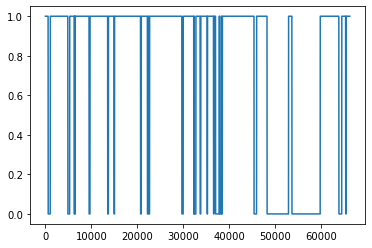

In [385]:
plt.plot(occupancy_state[:,1],label = 'ground truth')


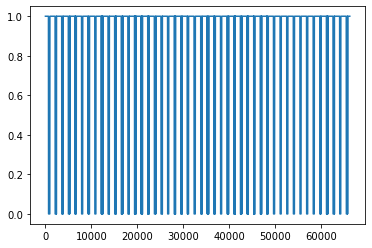

In [386]:
plt.plot(prediction,label ="prediction")

In [346]:
len(train_dataset.data)

33690

In [363]:
train_dataset.data[:,0]

array([0.01612986, 0.01614317, 0.01609106, ..., 0.01624878, 0.01620916,
       0.01621163])

In [44]:
data1 = train_dataset.data[:,0]  # 第一个数组
data2 = test_dataset2.data[:,0]  # 第二个数组

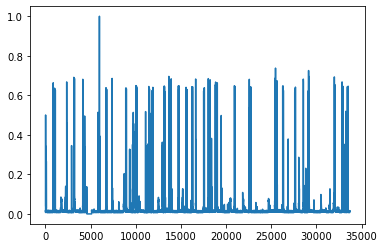

In [46]:
plt.plot(data1[0:38000])

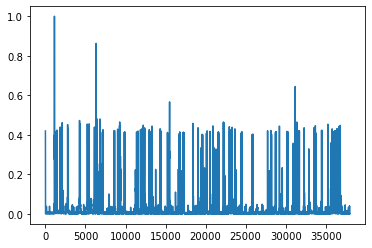

In [47]:
plt.plot(data2[0:38000])

ERROR! Session/line number was not unique in database. History logging moved to new session 3049


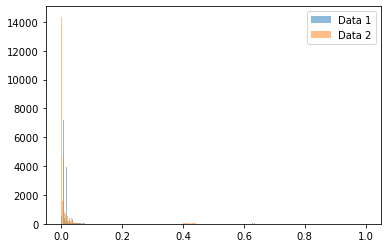

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# 假设这是你的数据
data1 = train_dataset.data[:,0]  # 第一个数组
data2 = test_dataset2.data[:,0]  # 第二个数组

# 绘制直方图
plt.hist(data1, bins=1000, alpha=0.5, label='Data 1')
plt.hist(data2, bins=1000, alpha=0.5, label='Data 2')

# 添加图例
plt.legend(loc='upper right')

# 显示图表
plt.show()

In [13]:
prediction

NameError: name 'prediction' is not defined

In [70]:
import numpy as np

def find_transition_points(y):
    """
    Find transition points in the y array.
    """
    diff = np.diff(y)
    pos_transitions = np.where(diff > 0)[0] + 1  # From 0 to 1
    neg_transitions = np.where(diff < 0)[0] + 1  # From 1 to 0
    return pos_transitions, neg_transitions

def calculate_f1(prediction, y_test, tolerance):
    # Find transition points in y_test
    pos_transitions_y_test, neg_transitions_y_test = find_transition_points(y_test)

    # Find transition points in prediction
    pos_transitions_prediction, neg_transitions_prediction = find_transition_points(prediction)

    # Initialize counters
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    true_negatives = 0

    # Calculate TP, FP, TN, FN
    for i in range(len(pos_transitions_y_test)):
        closest_index = np.argmin(np.abs(pos_transitions_prediction - pos_transitions_y_test[i]))
        if np.abs(pos_transitions_prediction[closest_index] - pos_transitions_y_test[i]) <= tolerance:
            true_positives += 1
            pos_transitions_prediction = np.delete(pos_transitions_prediction, closest_index)
    false_positives += len(pos_transitions_prediction)

    for i in range(len(neg_transitions_y_test)):
        closest_index = np.argmin(np.abs(neg_transitions_prediction - neg_transitions_y_test[i]))
        if np.abs(neg_transitions_prediction[closest_index] - neg_transitions_y_test[i]) <= tolerance:
            true_negatives += 1
            neg_transitions_prediction = np.delete(neg_transitions_prediction, closest_index)
    false_negatives += len(neg_transitions_prediction)

    # Calculate F1 score
    if true_positives + false_positives == 0:
        precision = 0
    else:
        precision = true_positives / (true_positives + false_positives)

    if true_positives + false_negatives == 0:
        recall = 0
    else:
        recall = true_positives / (true_positives + false_negatives)

    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)

    # Calculate average fragment length for FP and FN
    # FP waste
    # if false_positives == 0:
    #     average_fragment_length_fp = 0
    # else:
    #     total_length_fp = 0
    #     for transition in pos_transitions_prediction:
    #         length = 1
    #         while transition + length-1>len(y_test)-1 and prediction[transition + length-1] == 1:
    #             length += 1
    #         total_length_fp += length
    #     average_fragment_length_fp = total_length_fp / false_positives
    #
    # if false_negatives == 0:
    #     average_fragment_length_fn = 0
    # else:
    #     total_length_fn = 0
    #     for transition in neg_transitions_prediction:
    #         length = 1
    #         while transition + length-1>len(y_test)-1 and y_test[transition + length-1] == 1:
    #             length += 1
    #
    #         total_length_fn += length
    #     average_fragment_length_fn = total_length_fn / false_negatives

    # return f1, precision, recall, average_fragment_length_fp, average_fragment_length_fn
    return f1, precision, recall
# Example usage
prediction = np.array([0, 1, 1, 0, 0, 1, 1, 0, 1, 0])
y_test = np.array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1])
tolerance = 5

# f1_score, precision, recall, fp_length, fn_length = calculate_f1(prediction, y_test, tolerance)
f1_score, precision, recall = calculate_f1(prediction, y_test, tolerance)

print(f"F1 score: {f1_score}")
print(f"precision: {precision}")
print(f"recall: {recall}")
# print(f"fp_length: {fp_length}")
# print(f"fn_length: {fn_length}")

F1 score: 0.8571428571428571
precision: 1.0
recall: 0.75


In [ ]:
# Example usage
prediction = np.array([0, 1, 1, 0, 0, 1, 1, 0, 1, 0])
y_test = np.array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1])


In [1]:
import numpy as np

def find_transition_points(y):
    """
    Find transition points in the y array.
    """
    diff = np.diff(y)
    pos_transitions = np.where(diff > 0)[0] + 1  # From 0 to 1
    neg_transitions = np.where(diff < 0)[0] + 1  # From 1 to 0
    return pos_transitions, neg_transitions

def calculate_f1(prediction, y_test, tolerance):
    # Find transition points in y_test
    pos_transitions_y_test, neg_transitions_y_test = find_transition_points(y_test)

    # Find transition points in prediction
    pos_transitions_prediction, neg_transitions_prediction = find_transition_points(prediction)

    # Initialize counters
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    true_negatives = 0

    # Calculate TP, FP, TN, FN
    for i in range(len(pos_transitions_y_test)):
        closest_index = np.argmin(np.abs(pos_transitions_prediction - pos_transitions_y_test[i]))
        if np.abs(pos_transitions_prediction[closest_index] - pos_transitions_y_test[i]) <= tolerance:
            true_positives += 1
        else:
            false_negatives += 1

    for i in range(len(neg_transitions_y_test)):
        closest_index = np.argmin(np.abs(neg_transitions_prediction - neg_transitions_y_test[i]))
        if np.abs(neg_transitions_prediction[closest_index] - neg_transitions_y_test[i]) <= tolerance:
            true_negatives += 1
        else:
            false_positives += 1

    # Calculate F1 score
    if true_positives + false_positives == 0:
        precision = 0
    else:
        precision = true_positives / (true_positives + false_positives)

    if true_positives + false_negatives == 0:
        recall = 0
    else:
        recall = true_positives / (true_positives + false_negatives)

    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)

    return f1, precision, recall

# Example usage
prediction = np.array([0, 1, 1, 0, 0, 1, 1, 0, 1, 0])
y_test = np.array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1])
tolerance = 2

f1_score = calculate_f1(prediction, y_test, tolerance)
print(f"F1 score: {f1_score}")


F1 score: 0.3333333333333333
